In [257]:
import os
import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import random

In [258]:
# riproducibilità
random.seed(42)
torch.manual_seed(42)

In [259]:
# CONFIGURAZIONE
base_dir = os.getcwd()
image_size = 224
batch_size = 32 #32, 16
n_components = 146
# 3, 8, 17, 40, 146
# dimensioni su cui vogliamo fare PCA, trovate con explained variance 
# e selezionado le soglie = [0.95, 0.85, 0.75, 0.65, 0.50]
epochs = 100
output_folder = os.path.join(base_dir, "pca_outputs")
save_path = os.path.join(output_folder, f'pca_data_{n_components}_augmented.pth')
pretty_labels = ['Adenocarcinoma', 'Large Cell', 'Normal', 'Squamous Cell']
log_txt_path = os.path.join(output_folder, "classification_reports.txt")

In [260]:
# RICARICA E TRAIN
data_dict = torch.load(save_path, weights_only=False)


X_train = torch.tensor(data_dict['train_data'], dtype=torch.float32)
y_train = torch.tensor(data_dict['train_labels'], dtype=torch.long)
X_val = torch.tensor(data_dict['val_data'], dtype=torch.float32)
y_val = torch.tensor(data_dict['val_labels'], dtype=torch.long)
X_test = torch.tensor(data_dict['test_data'], dtype=torch.float32)
y_test = torch.tensor(data_dict['test_labels'], dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

C:\Users\noemi\AppData\Local\Temp\ipykernel_12096\949298212.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(data_dict['train_labels'], dtype=torch.long)


In [ ]:
# RETE
class FeedforwardNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        return self.fc3(x)



In [262]:
model = FeedforwardNet(n_components, 256, len(data_dict['class_names'])) #128, 64
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

# === CLASS WEIGHTS ===
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32)
# === LOSS, OPTIMIZER, SCHEDULER ===
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [263]:
# TRAINING con validazione ed early stopping
def train_model(patience=10):
    best_val_loss = float('inf')
    trigger_times = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (output.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)
        train_acc = 100 * correct / total

        # VALIDAZIONE
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
                val_correct += (output.argmax(1) == y_batch).sum().item()
                val_total += y_batch.size(0)
        val_acc = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # EARLY STOPPING
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            best_model_state = model.state_dict()
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("🛑 Early stopping triggered.")
                break

    # Restore best model
    model.load_state_dict(best_model_state)

train_model()


Epoch 1/100 | Train Loss: 119.6452 | Train Acc: 55.59% | Val Loss: 2.7123 | Val Acc: 66.67%
Epoch 2/100 | Train Loss: 78.3548 | Train Acc: 73.74% | Val Loss: 2.3548 | Val Acc: 68.06%
Epoch 3/100 | Train Loss: 61.1004 | Train Acc: 79.97% | Val Loss: 2.0565 | Val Acc: 69.44%
Epoch 4/100 | Train Loss: 51.2350 | Train Acc: 83.49% | Val Loss: 1.9457 | Val Acc: 70.83%
Epoch 5/100 | Train Loss: 45.4894 | Train Acc: 85.56% | Val Loss: 1.7595 | Val Acc: 72.22%
Epoch 6/100 | Train Loss: 41.1761 | Train Acc: 87.33% | Val Loss: 1.8290 | Val Acc: 73.61%
Epoch 7/100 | Train Loss: 37.5015 | Train Acc: 87.90% | Val Loss: 1.9140 | Val Acc: 70.83%
Epoch 8/100 | Train Loss: 33.4878 | Train Acc: 89.90% | Val Loss: 1.8843 | Val Acc: 70.83%
Epoch 9/100 | Train Loss: 30.0405 | Train Acc: 90.92% | Val Loss: 1.8104 | Val Acc: 76.39%
Epoch 10/100 | Train Loss: 27.6161 | Train Acc: 91.54% | Val Loss: 1.8264 | Val Acc: 69.44%
Epoch 11/100 | Train Loss: 25.5939 | Train Acc: 92.28% | Val Loss: 1.5366 | Val Acc: 76.

In [264]:
# VALUTAZIONE FINALE
model.eval()
y_true = []
y_pred = []
test_loss, test_correct, test_total = 0, 0, 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        loss = criterion(output, y_batch)  # calcolo del test loss
        test_loss += loss.item()
        preds = output.argmax(1)

        y_true.extend(y_batch.tolist())
        y_pred.extend(preds.tolist())

        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)

# Metriche test
test_acc = 100 * test_correct / test_total
print(f"\n🧪 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")



🧪 Test Loss: 16.6079 | Test Accuracy: 53.65%


In [265]:
y_true, y_pred = [], []
test_loss, test_correct, test_total = 0, 0, 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        loss = criterion(output, y_batch)
        test_loss += loss.item()
        preds = output.argmax(1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(preds.tolist())
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)

test_acc = 100 * test_correct / test_total
print(f"\n\U0001F9EA Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

report_txt = classification_report(y_true, y_pred, target_names=pretty_labels)
print(f"Classification Report {n_components} PCA:\n\n{report_txt}")


🧪 Test Loss: 16.6079 | Test Accuracy: 53.65%
Classification Report 146 PCA:

                precision    recall  f1-score   support

Adenocarcinoma       0.64      0.15      0.24       120
    Large Cell       0.38      0.80      0.52        51
        Normal       0.68      0.96      0.79        54
 Squamous Cell       0.57      0.64      0.60        90

      accuracy                           0.54       315
     macro avg       0.57      0.64      0.54       315
  weighted avg       0.58      0.54      0.48       315



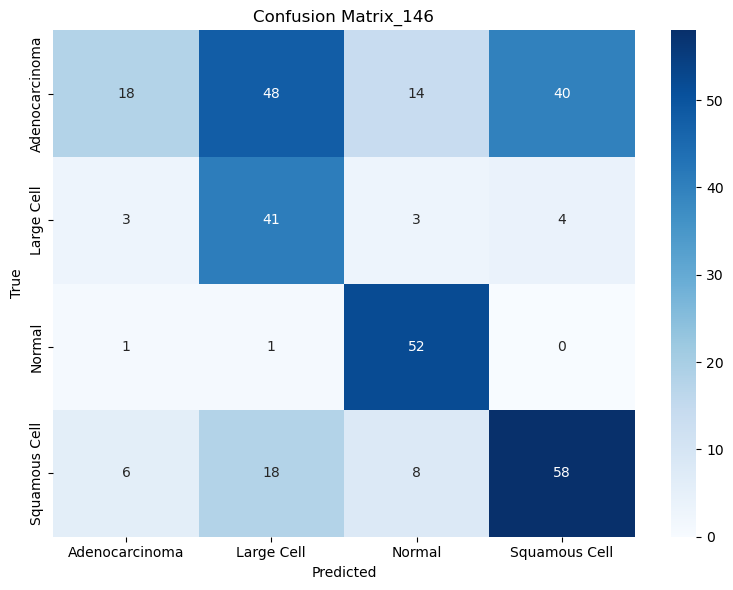

In [266]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
title = f'Confusion Matrix_{n_components}'
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=pretty_labels, yticklabels=pretty_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(title)
plot_path = os.path.join(output_folder, f'{title}.png')
plt.savefig(plot_path)
plt.tight_layout()
plt.show()